# AS - TME7
2018--2019

---

Binome : Juliette Ortholand, Stieban Fernandez

Modèles de séquence (réccurents)
- Modèle sur les caractères (prédire classe)
- Modèle génératif

Données Page AS@DAC
-> names (classes) :
- english.txt
- french.txt
- italian.txt
- ...

Chaque caractère en 1-hot -> char-embedding

Etat précédent : s0 s1, s2, ... application d'une fonction f

+

Classifieur

On travaille avec des batchs

-> remplir caractère vide par 0 par ex

---

Pour les modèles génératifs : longueur du prénom + 1 caractère pour déterminer la fin de la chaine :

Appliquer un masque : 1 s'il y a un caractère (+ caractère de fin) sinon 0

-> Prédire à chaque fois l'état (/caractère) suivant.

Utilisation : 
- Est-ce que "Pierre" est un prénom anglais ? (Calcul de la vraisemblance)
- Générer des prénoms

---

Parcourir les fichiers du répértoire avec glob('*.txt')

In [1]:
import torch
import torch.nn as nn
from unidecode import unidecode

In [8]:
from pathlib import Path

gen = Path("data/names").glob("*.txt")

L = []
D = {}
for label, file in enumerate(gen):
    
    lang = str(file).split("\\")[-1].split(".")[0]
    D[lang] = label
    
    with open(str(file), "r",encoding = 'utf8') as f:
        names = f.read().split("\n")
    for name in names:
        # Nettoyage
        name = "".join([c for c in unidecode(name.lower()) if c.isalpha()])
        L.append((name, label))
        
D, L

({'Arabic': 0,
  'Chinese': 1,
  'Czech': 2,
  'Dutch': 3,
  'English': 4,
  'French': 5,
  'German': 6,
  'Greek': 7,
  'Irish': 8,
  'Italian': 9,
  'Japanese': 10,
  'Korean': 11,
  'Polish': 12,
  'Portuguese': 13,
  'Russian': 14,
  'Scottish': 15,
  'Spanish': 16,
  'Vietnamese': 17},
 [('khoury', 0),
  ('nahas', 0),
  ('daher', 0),
  ('gerges', 0),
  ('nazari', 0),
  ('maalouf', 0),
  ('gerges', 0),
  ('naifeh', 0),
  ('guirguis', 0),
  ('baba', 0),
  ('sabbagh', 0),
  ('attia', 0),
  ('tahan', 0),
  ('haddad', 0),
  ('aswad', 0),
  ('najjar', 0),
  ('dagher', 0),
  ('maloof', 0),
  ('isa', 0),
  ('asghar', 0),
  ('nader', 0),
  ('gaber', 0),
  ('abboud', 0),
  ('maalouf', 0),
  ('zogby', 0),
  ('srour', 0),
  ('bahar', 0),
  ('mustafa', 0),
  ('hanania', 0),
  ('daher', 0),
  ('tuma', 0),
  ('nahas', 0),
  ('saliba', 0),
  ('shamoon', 0),
  ('handal', 0),
  ('baba', 0),
  ('amari', 0),
  ('bahar', 0),
  ('atiyeh', 0),
  ('said', 0),
  ('khouri', 0),
  ('tahan', 0),
  ('baba', 0

In [40]:


cod_char = lambda x: ord(x)-96

def encode_name(name,n):
    res =[cod_char(x) for x in name]
    for i in range(n-len(res)):
        res.append(0)
    return res

def data_loader(data, batch_size,n):
    emb = nn.Embedding(27,10)
    x = []
    y = []
    for name,label in data:
        encod = torch.tensor([encode_name(name,n)])
        x.append(emb(encod).tolist())
        y.append(label)
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x,y

In [44]:
x,y = data_loader(L, 1,20)

In [47]:
x[0][0][0]

tensor([-1.3652,  0.5527, -2.1435, -0.7498, -2.6038,  1.6770, -1.0571, -0.5050,
         0.2788,  1.0850])

In [151]:
class Rec(nn.Module):
    
    def __init__(self):
        super(Rec, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
            nn.Linear(15, 5),
        )
        
        self.clas = nn.Sequential(
            nn.Linear(100, 18)
        )
    def forward(self, X):
        init = torch.zeros(len(X),5)
        interm = torch.cat([init,X[:,0,0]],1)
        out = []
        for i in range(len(X[0][0])):
            res = self.seq1[i](interm)
            out.append(res.view(1,len(res),len(res[0])))
            interm = torch.cat([res,X[:,0,i]],1)
        out = torch.cat(out).view(len(X),-1)
        out = self.clas(out)
        return out
    
    def score(self,ypred,y):
        score = 0
        if len(y) != len(ypred):
            print('ERREUR')
        for i in range(0,len(y)):
            if y[i] == ypred[i].argmax():
                score += 1
        return(score/len(y))

In [155]:
model = Rec()
loss = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

train_loss = []
val_loss = []

train_score = []
val_score = []


### Train
#--------------------------------------------------------
for i in range(15):
    print(i)
    ####### TRAIN #######
    costs_train = []
    scores_train = []
    
    out_train = model(x_train)
    cost_train = loss(out_train, y_train)
    optim.zero_grad()
    cost_train.backward()
    optim.step()
    costs_train.append(cost_train)
    scores_train.append(model.score(out_train, y_train))
    train_loss.append(torch.tensor(costs_train).mean())
    train_score.append(torch.tensor(scores_train).mean())
    
    ####### VALID #######
    costs_val = []
    scores_val = []
    
    out_test = model(x_test)
    cost_test = loss(out_test, y_test)
    costs_val.append(cost_test)
    scores_val.append(model.score(out_test,y_test))
    val_score.append(torch.tensor(scores_val).mean())
    val_loss.append(torch.tensor(costs_val).mean())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


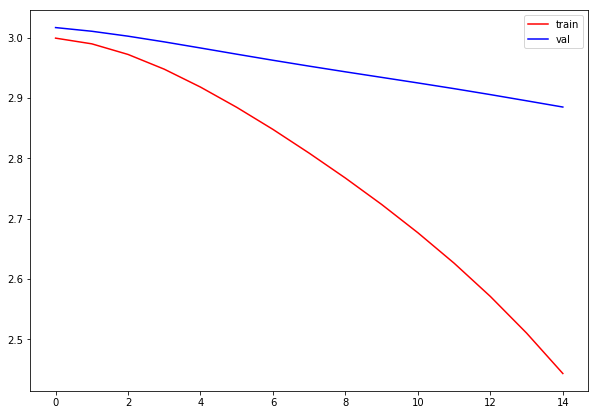

In [156]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(train_loss, c="red", label="train")
plt.plot(val_loss, c="b", label="val")
plt.legend(loc="best")
plt.show()

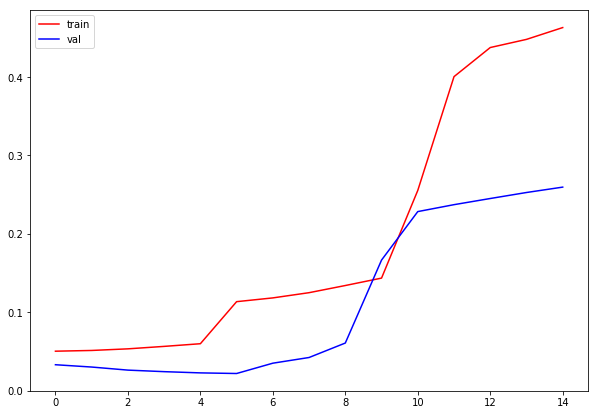

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(train_score, c="red", label="train")
plt.plot(val_score, c="b", label="val")
plt.legend(loc="best")
plt.show()